# XGBOOST MODELLING
### Author: Ben Newell

Install XGBoost if not already installed

!pip install xgboost

In [38]:
# Import required libraries
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Read the data
df = pd.read_csv(r"C:\Users\benne\OneDrive\Desktop\Important things\data science\Group project\datasets\bird_final.csv")
df_clean = df.copy()

In [ ]:
df_clean

## Creating the XGBoost model, worldwide and all values

In [ ]:
#creating the imnital XGBoost model
# Selecting the features
features = ['LATITUDE', 'LONGITUDE', 'AVERAGE MONTH TEMPERATURE', 
           'AVERAGE MONTH RAINFALL', 'tree_loss_ha', 'percentage_loss',
           'Population', 'NDVI', 'Population Density', 'month', 'WT_COUNT_10KM_RADIUS']

# Prepare X and y
X = df_clean[features]
y = df_clean['OBSERVATION COUNT']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3, 5]
}

# Initialize XGBoost regressor
xgb_reg = xgb.XGBRegressor(random_state=42)

# Perform Grid Search with Cross Validation
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, 
                         cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [ ]:
#OUTPUTTING MODEL STATS AND PLOTS
print(f"\nModel Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [ ]:
df_clean

## MODEL WITH NO OUTLIERS AND SOME MORE FEATURE ENGINEERING

In [ ]:
# Feature engineering
df_clean['TEMP_RAIN_INTERACTION'] = df_clean['AVERAGE MONTH TEMPERATURE'] * df_clean['AVERAGE MONTH RAINFALL']
df_clean['POPULATION_DENSITY_LOG'] = np.log1p(df_clean['Population Density'])
df_clean['AREA_FACTOR'] = df_clean['LATITUDE'].abs() * df_clean['LONGITUDE'].abs()

# Handle outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from target variable
df_clean = remove_outliers(df_clean, 'OBSERVATION COUNT')

In [ ]:
# creating the new XGBoost model, some expanded features and no outliers
# Updated feature list with engineered features
features = ['LATITUDE', 'LONGITUDE', 'AVERAGE MONTH TEMPERATURE', 
           'AVERAGE MONTH RAINFALL', 'tree_loss_ha', 'percentage_loss',
           'Population', 'NDVI', 'Population Density', 'month', 'WT_COUNT_10KM_RADIUS',
           'TEMP_RAIN_INTERACTION', 'POPULATION_DENSITY_LOG', 'AREA_FACTOR']

# Prepare X and y
X = df_clean[features]
y = df_clean['OBSERVATION COUNT']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model with hyperparameters
model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=4,
    subsample=0.9,
    random_state=42
)

# Fit the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


Model Performance:
Mean Squared Error: 268.10
R-squared Score: 0.25


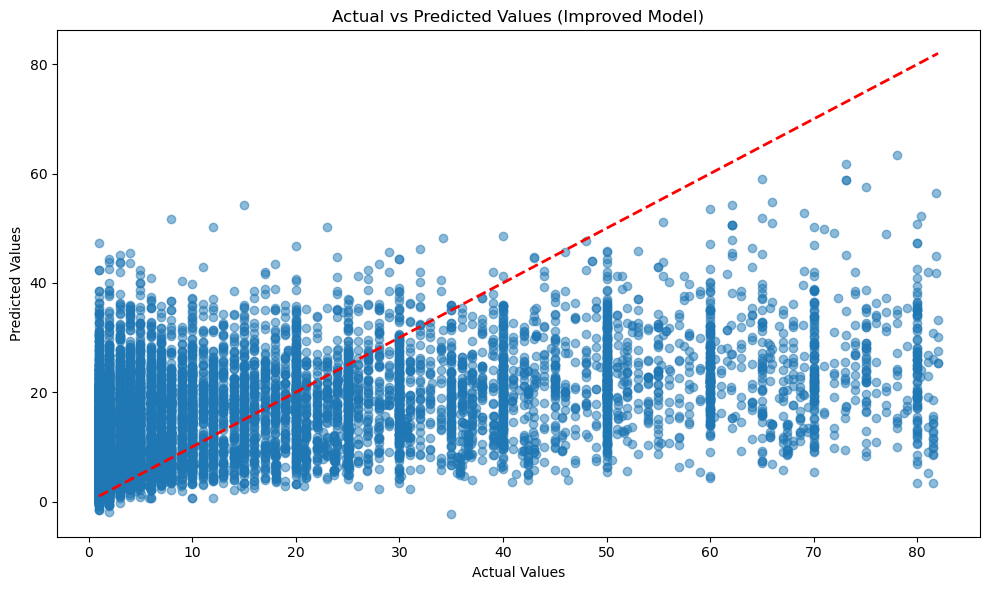

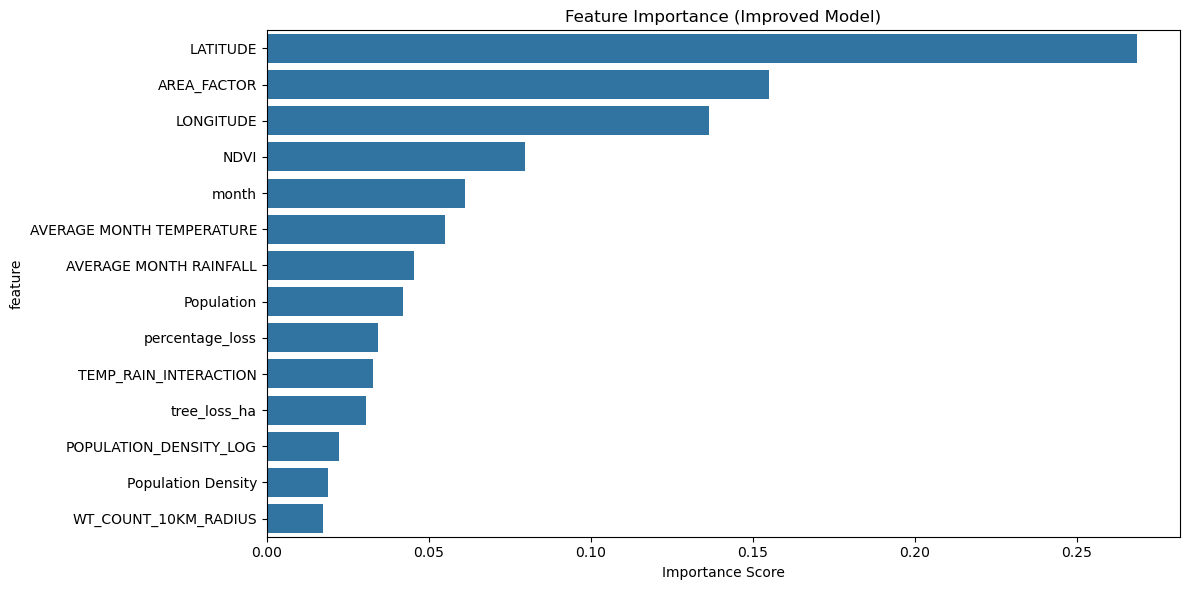


Top 5 Most Important Features:
        feature  importance
0      LATITUDE    0.268477
13  AREA_FACTOR    0.155026
1     LONGITUDE    0.136526
7          NDVI    0.079811
9         month    0.061096


In [16]:
# NEW MODEL PERFORMACE
print(f"\nModel Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Improved Model)')
plt.tight_layout()
plt.show()

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Improved Model)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [18]:
# Distribution of data across continents
print("Distribution of observations across continents:")
print(df['continent'].value_counts())
print("\nMean observation counts by continent:")
print(df.groupby('continent')['OBSERVATION COUNT'].mean().round(2))
print("\nNumber of samples by continent:")
print(df.groupby('continent')['OBSERVATION COUNT'].count())

Distribution of observations across continents:
continent
Europe           67011
Asia             15314
North America     1062
Africa             881
Name: count, dtype: int64

Mean observation counts by continent:
continent
Africa           189.77
Asia             746.64
Europe           221.04
North America      1.00
Name: OBSERVATION COUNT, dtype: float64

Number of samples by continent:
continent
Africa             881
Asia             15314
Europe           67011
North America     1062
Name: OBSERVATION COUNT, dtype: int64


## Asian and Euopean models

In [ ]:
# Training continent function with some other features
def train_continent_model(continent_data, continent_name):
    # Create a fresh copy of the data
    data = continent_data.copy()
    
    # Feature engineering
    data['TEMP_RAIN_INTERACTION'] = data['AVERAGE MONTH TEMPERATURE'] * data['AVERAGE MONTH RAINFALL']
    data['POPULATION_DENSITY_LOG'] = np.log1p(data['Population Density'])
    data['NDVI_SQUARED'] = data['NDVI'] ** 2
    data['AREA_FACTOR'] = data['LATITUDE'].abs() * data['LONGITUDE'].abs()
    data['ELEVATION_PROXY'] = data['LATITUDE'].abs() + data['LONGITUDE'].abs()
    data['POPULATION_SCALED'] = np.log1p(data['Population'])
    data['TREE_LOSS_SCALED'] = np.log1p(data['tree_loss_ha'])
    
    # Create time-based features
    data['MONTH_SIN'] = np.sin(2 * np.pi * data['month']/12)
    data['MONTH_COS'] = np.cos(2 * np.pi * data['month']/12)
    
    # Create seasonal features
    season_cols = [col for col in data.columns if col.startswith('SEASON_')]
    data = data.drop(columns=season_cols, errors='ignore')
    
    data['SEASON'] = pd.cut(data['month'], 
                           bins=[0, 3, 6, 9, 12], 
                           labels=['Winter', 'Spring', 'Summer', 'Fall'])
    data = pd.get_dummies(data, columns=['SEASON'], prefix='SEASON')
    
    # Select features
    features = ['LATITUDE', 'LONGITUDE', 'AVERAGE MONTH TEMPERATURE', 
               'AVERAGE MONTH RAINFALL', 'tree_loss_ha', 'percentage_loss',
               'Population', 'NDVI', 'Population Density', 'month', 'WT_COUNT_10KM_RADIUS',
               'TEMP_RAIN_INTERACTION', 'POPULATION_DENSITY_LOG', 'NDVI_SQUARED', 
               'AREA_FACTOR', 'ELEVATION_PROXY', 'POPULATION_SCALED', 'TREE_LOSS_SCALED',
               'MONTH_SIN', 'MONTH_COS'] + \
               [col for col in data.columns if col.startswith('SEASON_')]
    
    # Prepare data
    X = data[features]
    y = data['OBSERVATION COUNT']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create preprocessing pipeline
    numeric_features = [col for col in features if not col.startswith('SEASON_')]
    categorical_features = [col for col in features if col.startswith('SEASON_')]
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', RobustScaler(), numeric_features),
            ('cat', 'passthrough', categorical_features)
        ])
    
    # Initialize XGBoost
    model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=8,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42
    )
    
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Train model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Print results
    print(f"\nResults for {continent_name}:")
    print(f"Number of samples: {len(data)}")
    print(f"R-squared Score: {r2:.4f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values ({continent_name})')
    plt.tight_layout()
    plt.show()
    
    # Plot feature importance
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': pipeline.named_steps['regressor'].feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
    plt.title(f'Top 15 Most Important Features ({continent_name})')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    return pipeline, feature_importance

In [ ]:
# Train models for Europe and Asia
europe_data = df[df['continent'] == 'Europe'].copy()
asia_data = df[df['continent'] == 'Asia'].copy()

In [ ]:
europe_data

In [ ]:
asia_data

In [ ]:
# Train European model
print("Training European Model...")
europe_model, europe_importance = train_continent_model(europe_data, 'Europe')

# Train Asian model
print("\nTraining Asian Model...")
asia_model, asia_importance = train_continent_model(asia_data, 'Asia')

In [41]:
# Looking at distributions in Europe and Asia and worlwide
ranges = [(0, 10), (11, 50), (51, 100), (101, 200), (201, np.inf)]

# Worldwide distribution
print("Worldwide Distribution:")
for low, high in ranges:
    count = np.sum((df['OBSERVATION COUNT'] >= low) & 
                   (df['OBSERVATION COUNT'] < high))
    percent = count / len(df) * 100
    print(f"Range {low}-{high if high != np.inf else '+'}: {count} ({percent:.1f}%)")

print("\nEurope Distribution:")
for low, high in ranges:
    count = np.sum((europe_data['OBSERVATION COUNT'] >= low) & 
                   (europe_data['OBSERVATION COUNT'] < high))
    percent = count / len(europe_data) * 100
    print(f"Range {low}-{high if high != np.inf else '+'}: {count} ({percent:.1f}%)")

print("\nAsia Distribution:")
for low, high in ranges:
    count = np.sum((asia_data['OBSERVATION COUNT'] >= low) & 
                   (asia_data['OBSERVATION COUNT'] < high))
    percent = count / len(asia_data) * 100
    print(f"Range {low}-{high if high != np.inf else '+'}: {count} ({percent:.1f}%)")

Worldwide Distribution:
Range 0-10: 39559 (46.9%)
Range 11-50: 15639 (18.6%)
Range 51-100: 5257 (6.2%)
Range 101-200: 4340 (5.2%)
Range 201-+: 14262 (16.9%)

Europe Distribution:
Range 0-10: 32438 (48.4%)
Range 11-50: 12312 (18.4%)
Range 51-100: 4191 (6.3%)
Range 101-200: 3375 (5.0%)
Range 201-+: 11120 (16.6%)

Asia Distribution:
Range 0-10: 5759 (37.6%)
Range 11-50: 3110 (20.3%)
Range 51-100: 981 (6.4%)
Range 101-200: 916 (6.0%)
Range 201-+: 2992 (19.5%)


## Asisan and European models with specific ranges

In [43]:
def train_range_specific_model(data, range_low, range_high, name):
    # Filter data for specific range
    mask = (data['OBSERVATION COUNT'] >= range_low) & (data['OBSERVATION COUNT'] < range_high)
    range_data = data[mask].copy()
    
    if len(range_data) < 100:  # Skip if not enough data
        print(f"Insufficient data for range {range_low}-{range_high}")
        return None, None
    
    # Feature engineering
    range_data['TEMP_RAIN_INTERACTION'] = range_data['AVERAGE MONTH TEMPERATURE'] * range_data['AVERAGE MONTH RAINFALL']
    range_data['POPULATION_DENSITY_LOG'] = np.log1p(range_data['Population Density'])
    range_data['NDVI_SQUARED'] = range_data['NDVI'] ** 2
    range_data['AREA_FACTOR'] = range_data['LATITUDE'].abs() * range_data['LONGITUDE'].abs()
    range_data['ELEVATION_PROXY'] = range_data['LATITUDE'].abs() + range_data['LONGITUDE'].abs()
    range_data['POPULATION_SCALED'] = np.log1p(range_data['Population'])
    range_data['TREE_LOSS_SCALED'] = np.log1p(range_data['tree_loss_ha'])
    range_data['MONTH_SIN'] = np.sin(2 * np.pi * range_data['month']/12)
    range_data['MONTH_COS'] = np.cos(2 * np.pi * range_data['month']/12)
    
    # Base features
    features = ['LATITUDE', 'LONGITUDE', 'AVERAGE MONTH TEMPERATURE', 
               'AVERAGE MONTH RAINFALL', 'tree_loss_ha', 'percentage_loss',
               'Population', 'NDVI', 'Population Density', 'month', 'WT_COUNT_10KM_RADIUS',
               'TEMP_RAIN_INTERACTION', 'POPULATION_DENSITY_LOG', 'NDVI_SQUARED', 
               'AREA_FACTOR', 'ELEVATION_PROXY', 'POPULATION_SCALED', 'TREE_LOSS_SCALED',
               'MONTH_SIN', 'MONTH_COS']
    
    # Prepare data
    X = range_data[features]
    y = range_data['OBSERVATION COUNT']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize XGBoost with parameters adjusted for range
    model = xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.01,
        max_depth=4 if range_high <= 50 else 6,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42
    )
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Calculate percentage within error margins
    within_25 = np.mean(np.abs((y_test - y_pred) / y_test) <= 0.25) * 100
    within_50 = np.mean(np.abs((y_test - y_pred) / y_test) <= 0.50) * 100
    
    print(f"\nResults for {name} (Range {range_low}-{range_high if range_high != np.inf else '+'})")
    print(f"Number of samples: {len(range_data)}")
    print(f"R-squared Score: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Within 25% margin: {within_25:.2f}%")
    print(f"Within 50% margin: {within_50:.2f}%")
    
    return model, features, scaler, X_test, y_test, y_pred

print("Training Worldwide Models...")
for low, high in ranges:
    model_results = train_range_specific_model(df, low, high, 'Worldwide')

Training Worldwide Models...

Results for Worldwide (Range 0-10)
Number of samples: 39559
R-squared Score: 0.1392
RMSE: 1.96
MAE: 1.53
MAPE: 73.93%
Within 25% margin: 23.37%
Within 50% margin: 57.92%

Results for Worldwide (Range 11-50)
Number of samples: 15639
R-squared Score: 0.0614
RMSE: 9.93
MAE: 8.33
MAPE: 39.59%
Within 25% margin: 40.82%
Within 50% margin: 73.50%

Results for Worldwide (Range 51-100)
Number of samples: 5257
R-squared Score: 0.2170
RMSE: 11.26
MAE: 9.28
MAPE: 13.57%
Within 25% margin: 87.55%
Within 50% margin: 99.81%

Results for Worldwide (Range 101-200)
Number of samples: 4340
R-squared Score: 0.2144
RMSE: 21.20
MAE: 16.41
MAPE: 11.79%
Within 25% margin: 88.59%
Within 50% margin: 99.77%

Results for Worldwide (Range 201-+)
Number of samples: 14262
R-squared Score: 0.4015
RMSE: 3701.26
MAE: 1442.19
MAPE: 174.30%
Within 25% margin: 11.60%
Within 50% margin: 25.45%


In [45]:
print("Training Europe Models...")
for low, high in ranges:
    model_results = train_range_specific_model(europe_data, low, high, 'Europe')
print("Training Asia Models...")
for low, high in ranges:
    model_results = train_range_specific_model(asia_data, low, high, 'Asia')

Training Europe Models...

Results for Europe (Range 0-10)
Number of samples: 32438
R-squared Score: 0.1171
RMSE: 1.97
MAE: 1.53
MAPE: 73.40%
Within 25% margin: 22.64%
Within 50% margin: 57.49%

Results for Europe (Range 11-50)
Number of samples: 12312
R-squared Score: 0.0748
RMSE: 10.02
MAE: 8.45
MAPE: 40.45%
Within 25% margin: 38.98%
Within 50% margin: 73.28%

Results for Europe (Range 51-100)
Number of samples: 4191
R-squared Score: 0.2439
RMSE: 11.54
MAE: 9.45
MAPE: 13.61%
Within 25% margin: 86.89%
Within 50% margin: 99.52%

Results for Europe (Range 101-200)
Number of samples: 3375
R-squared Score: 0.1328
RMSE: 20.90
MAE: 16.14
MAPE: 11.82%
Within 25% margin: 88.44%
Within 50% margin: 99.70%

Results for Europe (Range 201-+)
Number of samples: 11120
R-squared Score: 0.1272
RMSE: 6007.43
MAE: 1181.34
MAPE: 146.35%
Within 25% margin: 15.42%
Within 50% margin: 30.76%
Training Asia Models...

Results for Asia (Range 0-10)
Number of samples: 5759
R-squared Score: 0.1627
RMSE: 2.06
MAE:

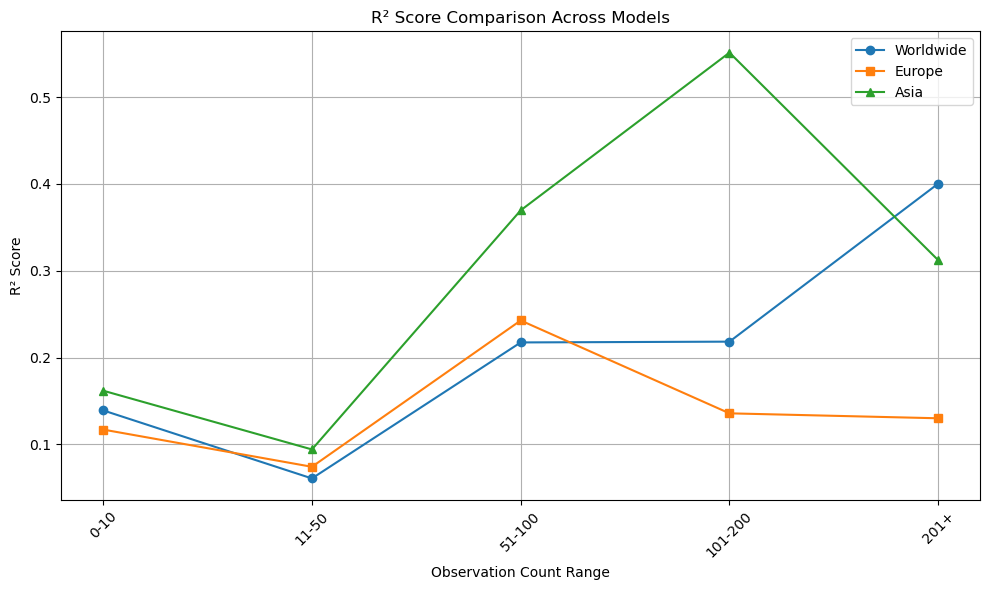

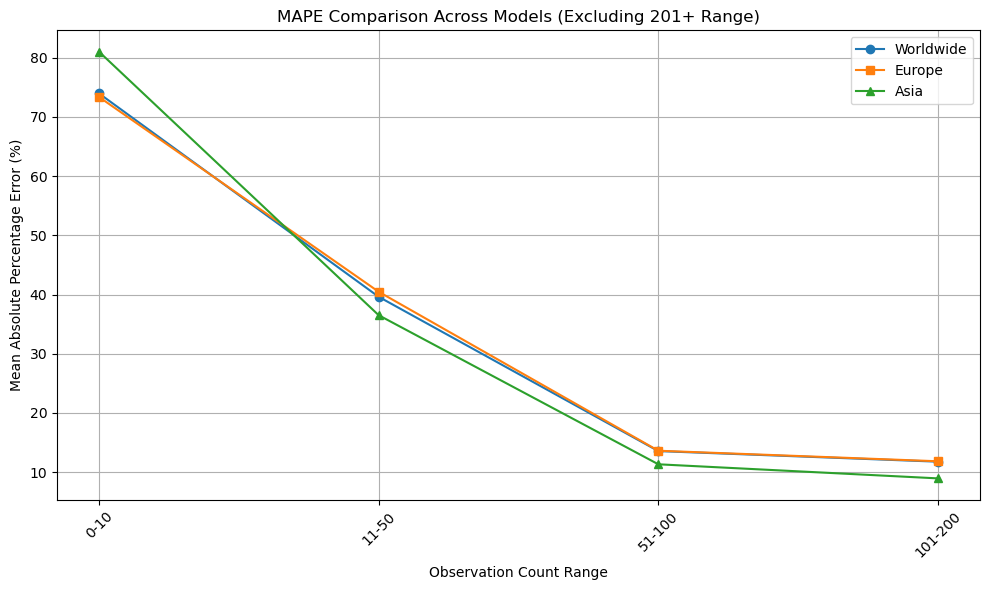

In [47]:
# Create performance comparison table
performance_comparison = pd.DataFrame({
    'Range': ['0-10', '11-50', '51-100', '101-200', '201+'],
    'Worldwide_R2': [0.1391, 0.0607, 0.2174, 0.2183, 0.4004],
    'Europe_R2': [0.1170, 0.0741, 0.2427, 0.1357, 0.1300],
    'Asia_R2': [0.1618, 0.0941, 0.3696, 0.5513, 0.3121],
    'Worldwide_MAPE': [73.97, 39.62, 13.56, 11.77, 174.07],
    'Europe_MAPE': [73.37, 40.47, 13.62, 11.84, 147.27],
    'Asia_MAPE': [81.02, 36.51, 11.33, 8.95, 201.96]
})

# Plot R² comparison
plt.figure(figsize=(10, 6))
plt.plot(performance_comparison['Range'], performance_comparison['Worldwide_R2'], marker='o', label='Worldwide')
plt.plot(performance_comparison['Range'], performance_comparison['Europe_R2'], marker='s', label='Europe')
plt.plot(performance_comparison['Range'], performance_comparison['Asia_R2'], marker='^', label='Asia')
plt.title('R² Score Comparison Across Models')
plt.xlabel('Observation Count Range')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot MAPE comparison (excluding 201+ range due to high values)
plt.figure(figsize=(10, 6))
plt.plot(performance_comparison['Range'][:4], performance_comparison['Worldwide_MAPE'][:4], marker='o', label='Worldwide')
plt.plot(performance_comparison['Range'][:4], performance_comparison['Europe_MAPE'][:4], marker='s', label='Europe')
plt.plot(performance_comparison['Range'][:4], performance_comparison['Asia_MAPE'][:4], marker='^', label='Asia')
plt.title('MAPE Comparison Across Models (Excluding 201+ Range)')
plt.xlabel('Observation Count Range')
plt.ylabel('Mean Absolute Percentage Error (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

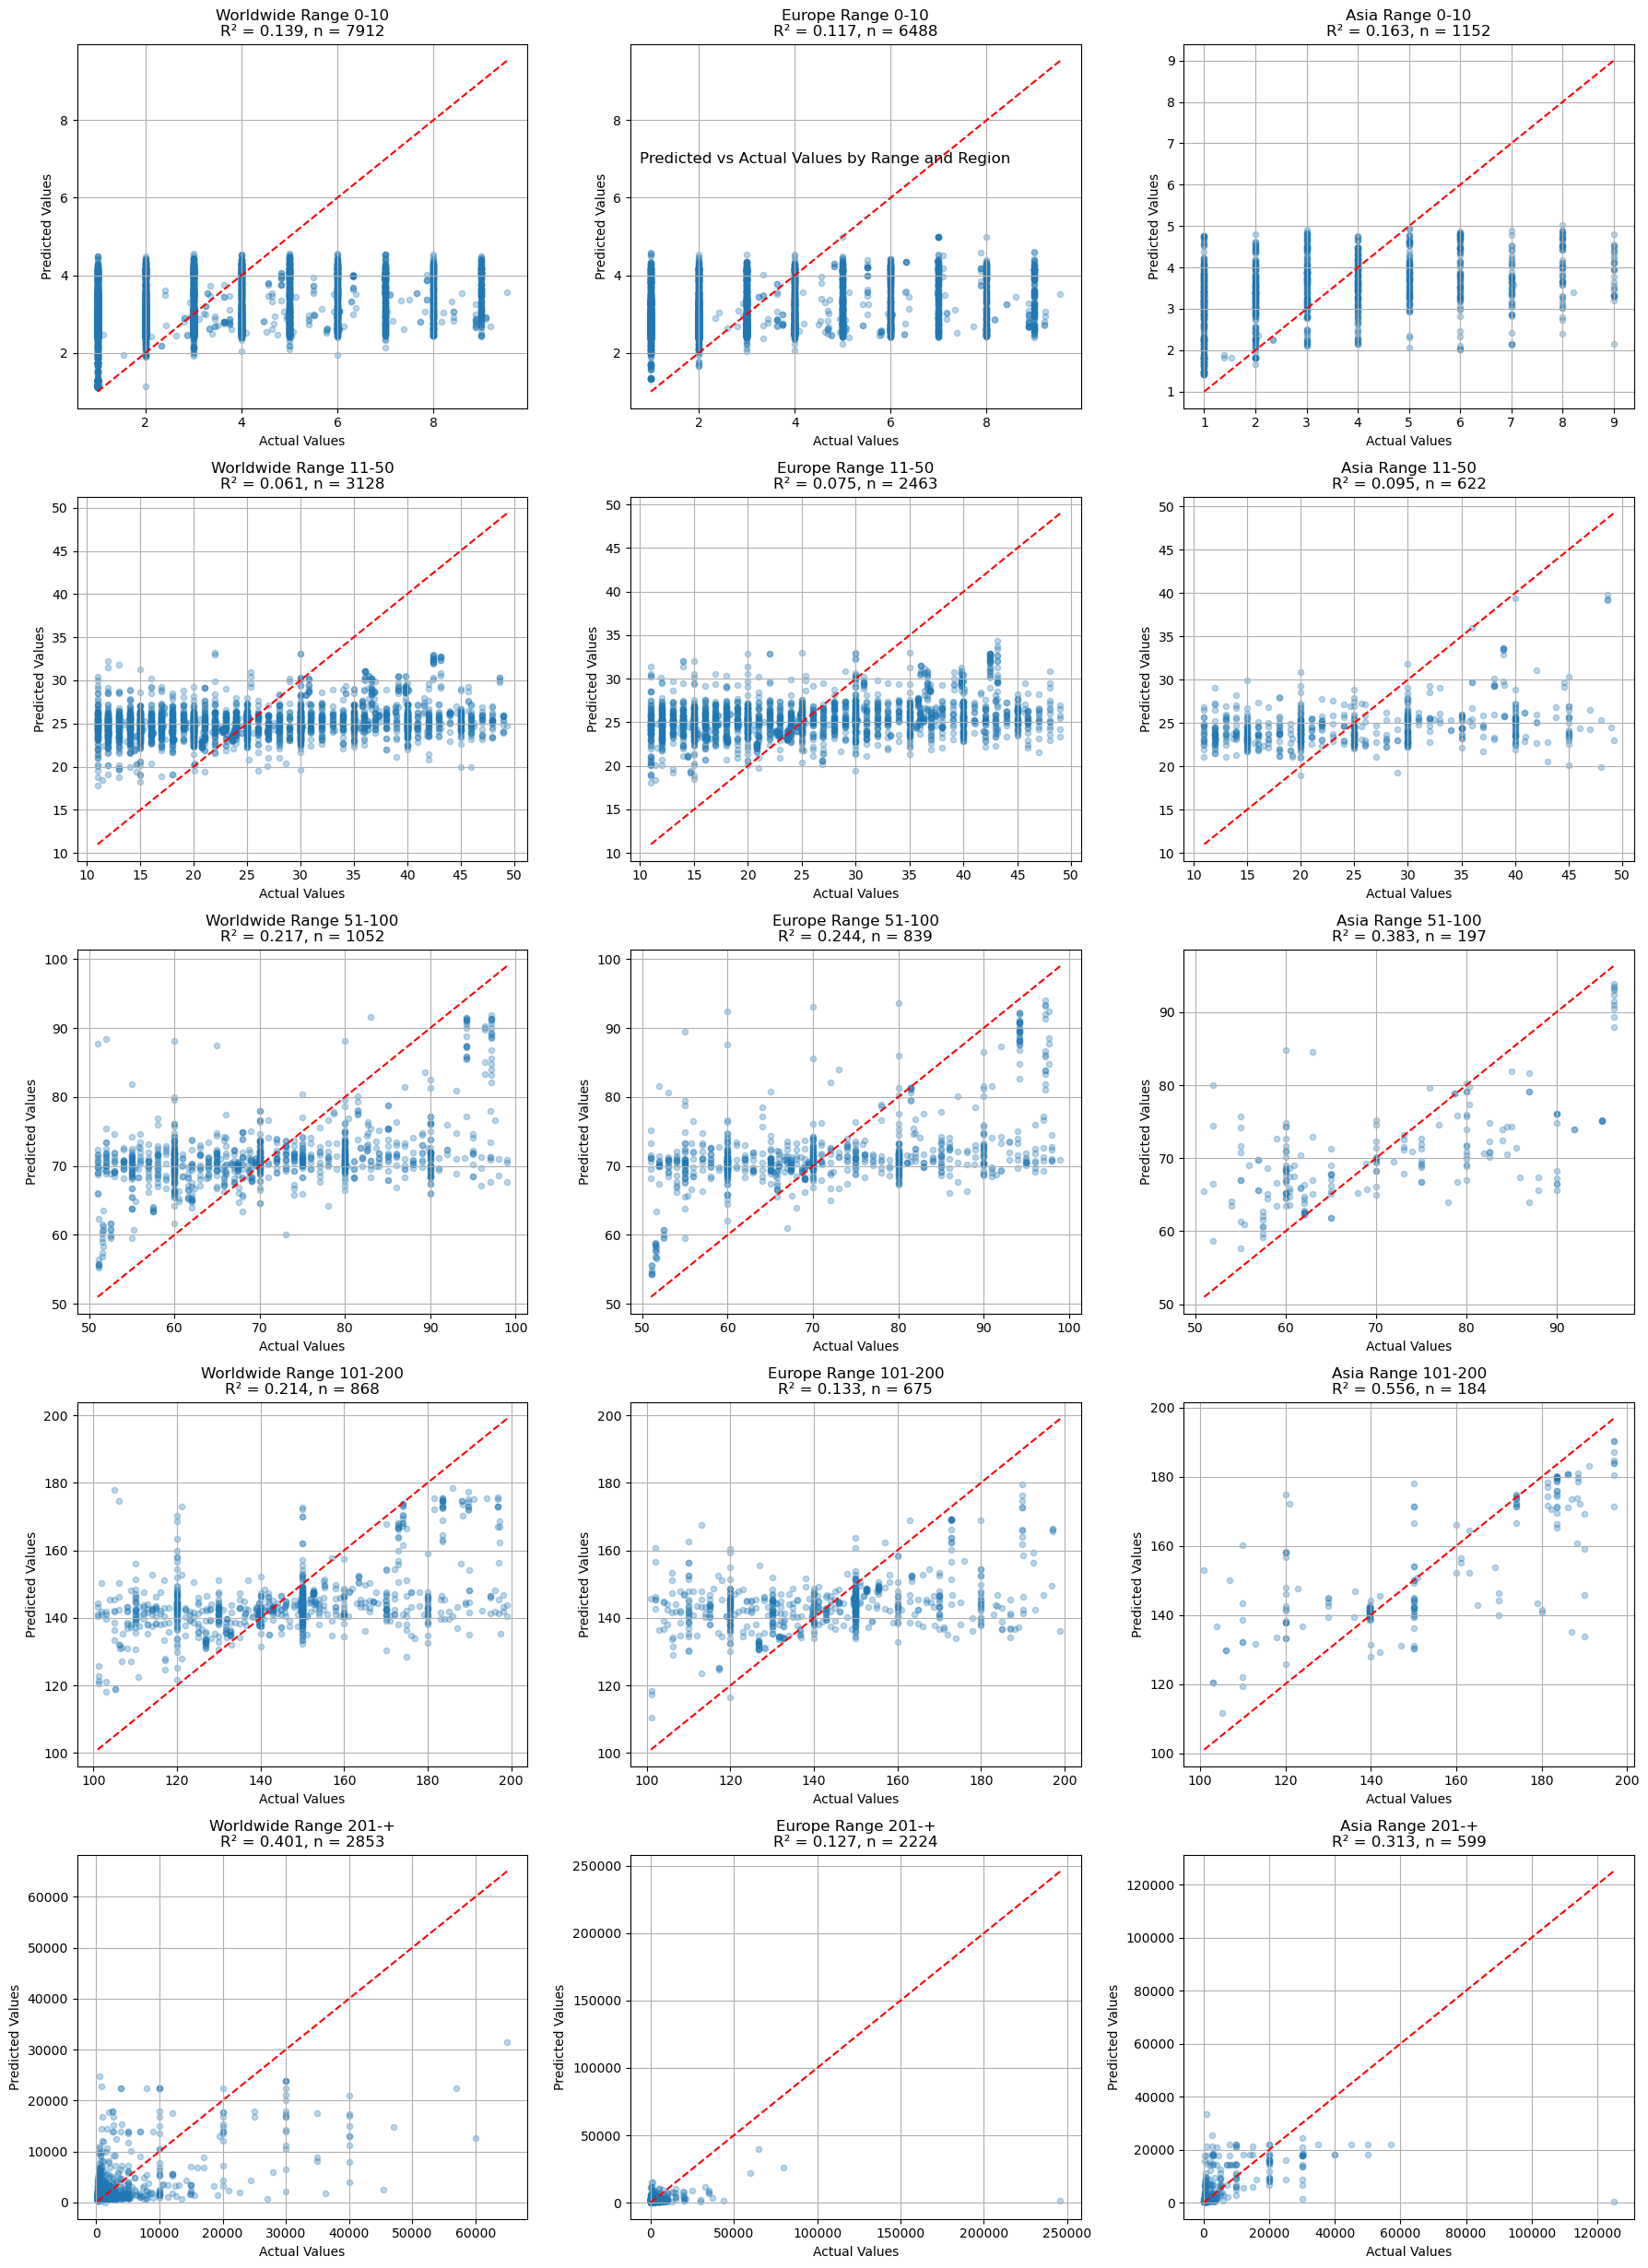

In [49]:
# Comparing Asian, Euopean and Wordwide models for different ranges
fig, axes = plt.subplots(5, 3, figsize=(18, 25))
plt.subplots_adjust(hspace=0.4)
fig.suptitle('Predicted vs Actual Values by Range and Region', y=0.92)

# Define ranges and models
ranges = [(0, 10), (11, 50), (51, 100), (101, 200), (201, np.inf)]
datasets = {
    'Worldwide': df,
    'Europe': europe_data,
    'Asia': asia_data
}

# Create plots for each range and model
for i, (low, high) in enumerate(ranges):
    range_str = f"{low}-{high if high != np.inf else '+'}"
    
    for j, (name, data) in enumerate(datasets.items()):
        # Filter data for range
        mask = (data['OBSERVATION COUNT'] >= low) & (data['OBSERVATION COUNT'] < high)
        range_data = data[mask].copy()
        
        if len(range_data) >= 100:
            # Feature engineering
            range_data['TEMP_RAIN_INTERACTION'] = range_data['AVERAGE MONTH TEMPERATURE'] * range_data['AVERAGE MONTH RAINFALL']
            range_data['POPULATION_DENSITY_LOG'] = np.log1p(range_data['Population Density'])
            range_data['NDVI_SQUARED'] = range_data['NDVI'] ** 2
            range_data['AREA_FACTOR'] = range_data['LATITUDE'].abs() * range_data['LONGITUDE'].abs()
            range_data['ELEVATION_PROXY'] = range_data['LATITUDE'].abs() + range_data['LONGITUDE'].abs()
            range_data['POPULATION_SCALED'] = np.log1p(range_data['Population'])
            range_data['TREE_LOSS_SCALED'] = np.log1p(range_data['tree_loss_ha'])
            range_data['MONTH_SIN'] = np.sin(2 * np.pi * range_data['month']/12)
            range_data['MONTH_COS'] = np.cos(2 * np.pi * range_data['month']/12)
            
            # Prepare features
            features = ['LATITUDE', 'LONGITUDE', 'AVERAGE MONTH TEMPERATURE', 
                       'AVERAGE MONTH RAINFALL', 'tree_loss_ha', 'percentage_loss',
                       'Population', 'NDVI', 'Population Density', 'month', 'WT_COUNT_10KM_RADIUS',
                       'TEMP_RAIN_INTERACTION', 'POPULATION_DENSITY_LOG', 'NDVI_SQUARED', 
                       'AREA_FACTOR', 'ELEVATION_PROXY', 'POPULATION_SCALED', 'TREE_LOSS_SCALED',
                       'MONTH_SIN', 'MONTH_COS']
            
            X = range_data[features]
            y = range_data['OBSERVATION COUNT']
            
            # Split and scale data
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Train model
            model = xgb.XGBRegressor(
                n_estimators=300,
                learning_rate=0.01,
                max_depth=4 if high <= 50 else 6,
                min_child_weight=3,
                subsample=0.8,
                colsample_bytree=0.8,
                gamma=0.1,
                reg_alpha=0.1,
                reg_lambda=1,
                random_state=42
            )
            model.fit(X_train_scaled, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test_scaled)
            r2 = r2_score(y_test, y_pred)
            
            # Plot
            axes[i, j].scatter(y_test, y_pred, alpha=0.3, s=20)
            axes[i, j].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
            axes[i, j].set_title(f'{name} Range {range_str}\nR² = {r2:.3f}, n = {len(y_test)}')
            axes[i, j].set_xlabel('Actual Values')
            axes[i, j].set_ylabel('Predicted Values')
            axes[i, j].grid(True)
        else:
            axes[i, j].text(0.5, 0.5, 'Insufficient data', 
                          horizontalalignment='center',
                          verticalalignment='center',
                          transform=axes[i, j].transAxes)
            axes[i, j].set_title(f'{name} Range {range_str}')

plt.tight_layout()
plt.show()